####Copyright https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans



In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid

In [ ]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [ ]:
import tarfile

with tarfile.open('oxford-iiit-pet.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [ ]:
from torch.utils.data import Dataset

#Extract labels  from the images names

In [ ]:
import os

data_dir = './data/oxford-iiit-pet/images'
files = os.listdir(data_dir)
files[:10]

['scottish_terrier_11.jpg',
 'samoyed_72.jpg',
 'pug_75.jpg',
 'yorkshire_terrier_176.jpg',
 'samoyed_25.jpg',
 'Birman_167.jpg',
 'Birman_145.jpg',
 'Russian_Blue_97.jpg',
 'shiba_inu_159.jpg',
 'Abyssinian_223.jpg']

In [ ]:
fname = files[1]
print(fname.split('_'))
' '.join(fname.split('_')[:-1])

['samoyed', '72.jpg']


'samoyed'

In [ ]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [ ]:
parse_breed(files[0])

'scottish terrier'

In [ ]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
#Creating a Custom PyTorch Dataset
import os
class PetsDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('jpg')]
    self.classes = list(set(parse_breed(fname) for fname in files))
    self.transform = transform

  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes.index(parse_breed(fname))
    return img, class_idx

In [ ]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(data_dir, T.Compose([T.Resize(img_size),
                                              T.Pad(8, padding_mode='reflect'),
                                              T.RandomCrop(img_size),
                                              T.ToTensor(),
                                              T.Normalize(*imagenet_stats)]))

In [ ]:
len(dataset)

7390

In [ ]:
#Denormalize the dataset to show images
import torch
import matplotlib.pyplot as plt

def denormalize(image, means, stds):
  if len(image.shape) == 3:
    image = image.unsqueeze(0)
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return image * stds + means

def show_image(img_tensor, label):
  print('label:', dataset.classes[label], '(' + str(label) + ')')
  img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
  plt.imshow(img_tensor)

label: pug (35)


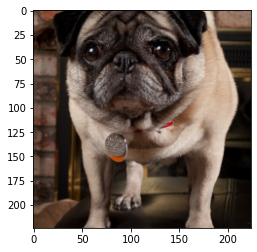

In [ ]:
show_image(*dataset[2])

#Creating training and validation datasets

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(6651, 739)

In [ ]:
#Convert the data into batches
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xlabel([]), ax.set_ylabel([])
    images = denormalize(images[:64], *imagenet_stats)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


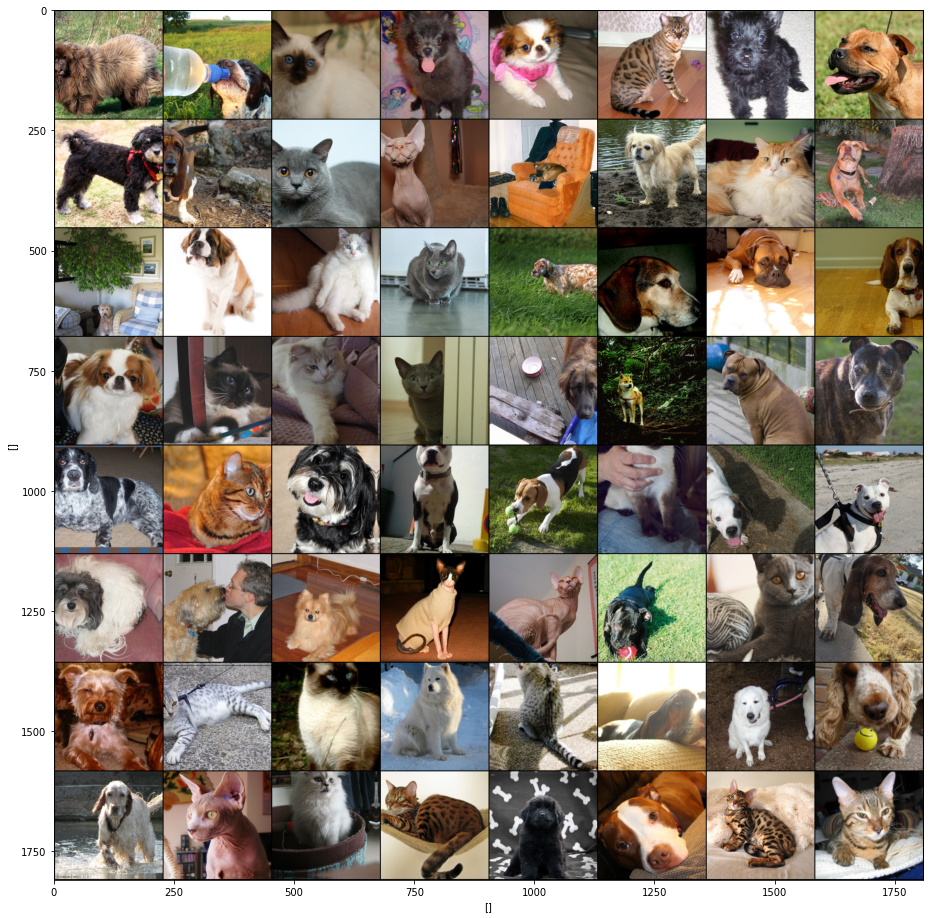

In [ ]:
show_batch(train_dl)

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}
  def validation_epoch_end(self, outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print('Epoch [{}], {}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
        epoch, "last_lr: {:.5f}" .format(result['lrs'][-1] if 'lrs' in result else ''),
        result['train_loss'], result['val_loss'], result['val_acc']
    ))

#GPU Utilities and training loop

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)


In [ ]:
#Defining the model for transfer learning
from torchvision import models
class PetsModel(ImageClassificationBase):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    self.network = models.resnet34(pretrained=pretrained)
    self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

  def forward(self, xb):
    return self.network(xb)

In [ ]:
from tqdm.notebook import tqdm
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean()
    model.epoch_end(epoch, result)
    history.append(result)
  return history
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


In [ ]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs=epochs,
                                             steps_per_epoch=len(train_loader))   
  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #Gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      
      optimizer.step()
      optimizer.zero_grad()
      #Record and update the learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history


In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Fine tuning the pretrained model


In [ ]:
model = PetsModel(len(dataset.classes))
to_device(model, device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
history = evaluate(model, valid_dl)
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.02663821540772915, 'val_loss': 3.9676384925842285}

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
